# MapReduce using SPARK

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook', font_scale=1.5)
sns.set_style('white')
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

# Table of Contents

* [SPARK](#SPARK)
    * Installing Spark locally
* [Spark Context](#Spark-Context)
    * [Create A RDD](#Create-A-RDD)
    * [Call `collect` on an RDD: Lazy Spark](#Call-collect-on-an-RDD:-Lazy-Spark)
    * [Operations on RDDs](#Operations-on-RDDs)
    * [Word Examples](#Word-Examples)
    * [Key Value Pairs](#Key-Value-Pairs)
    * [word count 1](#word-count-1)
    * [word count 2:  `reduceByKey()`](#word-count-2:--reduceByKey%28%29)
    * [Nested Syntax](#Nested-Syntax)
    * [Using Cache](#Using-Cache)
    * [Fun with words](#Fun-with-words)
    * [DataFrames](#DataFrames)
    * [Machine Learning](#Machine-Learning)


With shameless stealing of some code and text from:

- https://github.com/tdhopper/rta-pyspark-presentation/blob/master/slides.ipynb
- Databricks and Berkeley Spark MOOC: https://www.edx.org/course/introduction-big-data-apache-spark-uc-berkeleyx-cs100-1x

which you should go check out.

## Installing Spark locally


**Step 1: Install Apache Spark**

For example, for Mac users using Homebrew:

```
$ brew install apache-spark
```

**Step 2: Install the Java SDK version 1.8 or above for your platform (not just the JRE runtime)**

Make sure you can access commands such as `java` on your command line.

**Step 3: Install the latest findspark package using pip**

```
➜  ~  pip install findspark
Collecting findspark
  Downloading findspark-0.0.5-py2.py3-none-any.whl
Installing collected packages: findspark
Successfully installed findspark-0.0.5
```

# Spark Context

You can also use it directly from the notebook interface on the mac if you installed `apache-spark` using `brew` and also installed `findspark` above.

RDD Transformations: map(func), filter(func), flatMap(func)

RDD Actions: reduce(func), collect(), take(n), sum(), max(), min(), mean()



In [2]:
import findspark
findspark.init()

In [3]:
import pyspark
sc = pyspark.SparkContext()

In [4]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
sc.parallelize(range(1,10))

PythonRDD[1] at RDD at PythonRDD.scala:48

In [6]:
sc.parallelize(range(1,10)).first()

1

In [7]:
sc.parallelize(range(1,10)).filter(lambda x: x%2==1).collect()

[1, 3, 5, 7, 9]

In [8]:
sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).map(lambda x: x**2).sum()

385

### Create A RDD


In [9]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']

# the 2nd parameter: the number of partitions to cut the dataset into
wordsRDD = sc.parallelize(wordsList, 4)

# Print out the type of wordsRDD
print (type(wordsRDD))

<class 'pyspark.rdd.RDD'>


### Call `collect` on an RDD: Lazy Spark

Spark is lazy. Until you `collect`, nothing is actually run.

>Instead, they just remember the transformations applied to some base dataset (e.g. a file). The transformations are only computed when an action requires a result to be returned to the driver program.

In [10]:
wordsRDD.collect()

['cat', 'elephant', 'rat', 'rat', 'cat']

### Operations on RDDs

From the Spark Programming Guide:

>RDDs support two types of operations: transformations, which create a new dataset from an existing one, and actions, which return a value to the driver program after running a computation on the dataset. For example, map is a transformation that passes each dataset element through a function and returns a new RDD representing the results. On the other hand, reduce is an action that aggregates all the elements of the RDD using some function and returns the final result to the driver program (although there is also a parallel reduceByKey that returns a distributed dataset).

### Word Examples

In [11]:
def makePlural(word):
    return word + 's'

print (makePlural('cat'))

cats


Transform one RDD into another.

In [12]:
pluralRDD = wordsRDD.map(makePlural)
print (pluralRDD.first())
print (pluralRDD.take(2))


cats
['cats', 'elephants']


In [13]:
pluralRDD.take(1)

['cats']

In [14]:
pluralRDD.collect()

['cats', 'elephants', 'rats', 'rats', 'cats']

### Key Value Pairs

In [15]:
wordPairs = wordsRDD.map(lambda w: (w, 1))
print (wordPairs.collect())

[('cat', 1), ('elephant', 1), ('rat', 1), ('rat', 1), ('cat', 1)]


### WORD COUNT!

This little exercise shows how to use mapreduce to calculate the counts of individual words in a list.

In [16]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
wordCountsCollected = (wordsRDD
                       .map(lambda w: (w, 1))
                       .reduceByKey(lambda x,y: x+y)
                       .collect())
print (wordCountsCollected)

[('cat', 2), ('elephant', 1), ('rat', 2)]


![Tons of shuffling](https://databricks.gitbooks.io/databricks-spark-knowledge-base/content/images/reduce_by.png)

In [17]:
print ((wordsRDD
    .map(lambda w: (w, 1))
    .reduceByKey(lambda x,y: x+y)).toDebugString())

b'(4) PythonRDD[25] at RDD at PythonRDD.scala:48 []\n |  MapPartitionsRDD[24] at mapPartitions at PythonRDD.scala:427 []\n |  ShuffledRDD[23] at partitionBy at NativeMethodAccessorImpl.java:0 []\n +-(4) PairwiseRDD[22] at reduceByKey at <ipython-input-17-de218d677346>:3 []\n    |  PythonRDD[21] at reduceByKey at <ipython-input-17-de218d677346>:3 []\n    |  ParallelCollectionRDD[15] at parallelize at PythonRDD.scala:480 []'


### Using Cache

In [18]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
print (wordsRDD)
wordsRDD.count()

ParallelCollectionRDD[26] at parallelize at PythonRDD.scala:480


5

Normally, every operation is run from the start. This may be inefficient in many cases. So when appropriate, we may want to cache the result the first time an operation is run on an RDD.

In [19]:
#this is rerun from the start
wordsRDD.count()

5

In [20]:
#default storage level (MEMORY_ONLY)
wordsRDD.cache()#nothing done this is still lazy

ParallelCollectionRDD[26] at parallelize at PythonRDD.scala:480

In [21]:
#parallelize is rerun and cached because we told it to cache
wordsRDD.count()

5

In [22]:
#this `sc.parallelize` is not rerun in this case
wordsRDD.count()

5

Where is this useful: it is when you have branching parts or loops, so that you dont do things again and again. Spark, being "lazy" will rerun the chain again. So `cache` or `persist` serves as a checkpoint, breaking the RDD chain or the *lineage*.

In [23]:
birdsList=['heron','owl']
animList=wordsList+birdsList
animaldict={}
for e in wordsList:
    animaldict[e]='mammal'
for e in birdsList:
    animaldict[e]='bird'
animaldict

{'cat': 'mammal',
 'elephant': 'mammal',
 'heron': 'bird',
 'owl': 'bird',
 'rat': 'mammal'}

In [24]:
animsrdd = sc.parallelize(animList, 4)
animsrdd.cache()
#below runs the whole chain but causes cache to be populated
mammalcount=animsrdd.filter(lambda w: animaldict[w]=='mammal').count()
#now only the filter is carried out
birdcount=animsrdd.filter(lambda w: animaldict[w]=='bird').count()
print (mammalcount, birdcount)

5 2


### Exercises: Fun with MapReduce

Read http://spark.apache.org/docs/latest/programming-guide.html for some useful background and then try out the following exercises

The file `./sparklect/english.stop.txt` contains a list of English stopwords, while the file `./sparklect/shakes/juliuscaesar.txt` contains the entire text of Shakespeare's 'Julius Caesar'.

* Load all of the stopwords into a Python list
* Load the text of Julius Caesar into an RDD using the `sparkcontext.textfile()` method. Call it `juliusrdd`.

In [25]:
# Load English stopwords and the text of Julius Caesar
stopwords = open('./sparklect/english.stop.txt', 'r').read().split('\n')    
juliusrdd = sc.textFile('./sparklect/shakes/juliuscaesar.txt')


`sc.textFile(urlOrPath,minPartitions,useUnicode=True)`

* Returns an rdd of strings (one per line)
* Can read from many files, using wildcards (*)
* We normally use map right after and split/parse the lines


In [26]:
print('The number of lines in Julius Caesar is: {}'.format(juliusrdd.count()))

The number of lines in Julius Caesar is: 3094


How many words does Julius Caesar have? *Hint: use `flatMap()`*.

In [27]:
# Remove all punctuations and turn all words into lowercase
import string

translator = str.maketrans('', '', string.punctuation)
juliusrdd = juliusrdd.map(lambda x: x.lower().translate(translator).split())

In [28]:
from itertools import chain
wordsrdd = juliusrdd.flatMap(chain)
wordsrdd.count()

21201

Now print the first 20 words of Julius Caesar as a Python list.

In [29]:
wordsrdd.take(20)

['1599',
 'the',
 'tragedy',
 'of',
 'julius',
 'caesar',
 'by',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar',
 'roman',
 'statesman',
 'and',
 'general',
 'octavius',
 'triumvir',
 'after']

Now print the first 20 words of Julius Caesar, **after removing all the stopwords**. *Hint: use `filter()`*.

In [30]:
wordsrdd = wordsrdd.filter(lambda x: x not in stopwords)
wordsrdd.take(20)

['1599',
 'tragedy',
 'julius',
 'caesar',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar',
 'roman',
 'statesman',
 'general',
 'octavius',
 'triumvir',
 'caesars',
 'death',
 'augustus',
 'caesar',
 'emperor']

Now, use the word counting MapReduce code you've seen before. Count the number of times each word occurs and print the top 20 results as a list of tuples of the form `(word, count)`. *Hint: use `takeOrdered()` instead of `take()`*

In [31]:
wordsrdd.map(lambda t: (t, 1)).reduceByKey(lambda x,y: x+y).takeOrdered(20, key=lambda x: -x[1])

[('brutus', 366),
 ('caesar', 237),
 ('cassius', 227),
 ('antony', 128),
 ('thou', 116),
 ('casca', 72),
 ('good', 71),
 ('citizen', 69),
 ('men', 64),
 ('lucius', 59),
 ('man', 56),
 ('thy', 54),
 ('thee', 54),
 ('messala', 47),
 ('lord', 44),
 ('enter', 43),
 ('octavius', 43),
 ('rome', 43),
 ('caesars', 42),
 ('cinna', 40)]

Plot a bar graph. For each of the top 20 words on the X axis, represent the count on the Y axis.

In [32]:
top20words = wordsrdd.map(lambda t: (t, 1)).reduceByKey(lambda x,y: x+y).takeOrdered(20, key=lambda x: -x[1])

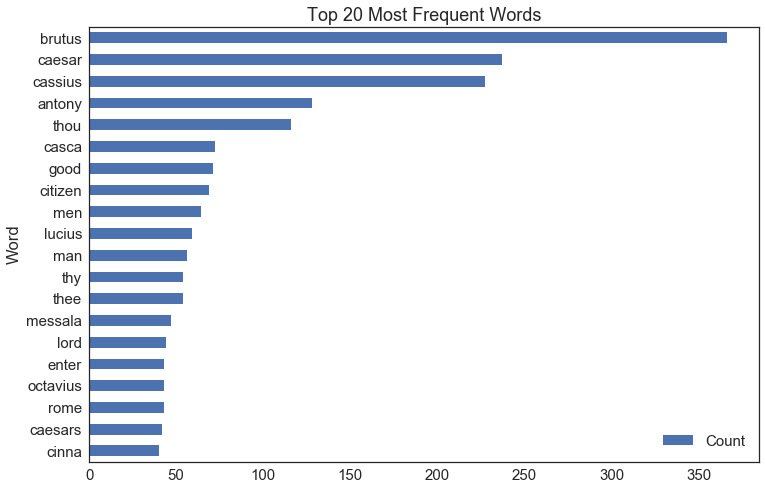

In [33]:
pd.DataFrame(top20words, columns=['Word', 'Count']).sort_values('Count').plot(x='Word', 
                                                                              y='Count', 
                                                                              kind='barh', 
                                                                              figsize=(12,8))
plt.title('Top 20 Most Frequent Words')
plt.show()

### Using partitions for parallelization

In order to make your code more efficient, you want to use all of the available processing power, even on a single laptop. If your machine has multiple cores, you can tune the number of partitions to use all of them! From http://www.stat.berkeley.edu/scf/paciorek-spark-2014.html:

>You want each partition to be able to fit in the memory availalbe on a node, and if you have multi-core nodes, you want that as many partitions as there are cores be able to fit in memory.

>For load-balancing you'll want at least as many partitions as total computational cores in your cluster and probably rather more partitions. The Spark documentation suggests 2-4 partitions (which they also seem to call slices) per CPU. Often there are 100-10,000 partitions. Another rule of thumb is that tasks should take at least 100 ms. If less than that, you may want to repartition to have fewer partitions.

In [34]:
shakesrdd=sc.textFile("./sparklect/shakes/*.txt", minPartitions=4)

Now calculate the top 20 words in all of the files that you just read.

In [35]:
# Remove all punctuations and turn all words into lowercase

translator = str.maketrans('', '', string.punctuation)
shakesrdd = shakesrdd.map(lambda x: x.lower().translate(translator).split())

In [36]:
# Count the frequency for each word
word_counts = shakesrdd.flatMap(chain).map(lambda t: (t, 1)).reduceByKey(lambda x,y: x+y)

In [37]:
# Remove stopwords and print 20 most frequent words
word_counts.filter(lambda x: x[0] not in stopwords).takeOrdered(20, key=lambda x: -x[1])

[('thou', 2129),
 ('thy', 1548),
 ('sir', 1320),
 ('thee', 1257),
 ('good', 1200),
 ('lord', 1116),
 ('love', 939),
 ('enter', 892),
 ('hath', 793),
 ('man', 783),
 ('ill', 768),
 ('make', 654),
 ('tis', 613),
 ('king', 596),
 ('give', 574),
 ('duke', 568),
 ('speak', 528),
 ('brutus', 478),
 ('time', 471),
 ('exit', 443)]

## Optional topic 1: DataFrames

Pandas and Spark dataframes can be easily converted to each other, making it easier to work with different data formats. This section shows some examples of each.

Convert Spark DataFrame to Pandas

`pandas_df = spark_df.toPandas()`

Create a Spark DataFrame from Pandas

`spark_df = context.createDataFrame(pandas_df)`

Must fit in memory.

![](https://ogirardot.files.wordpress.com/2015/05/rdd-vs-dataframe.png?w=640&h=360)

VERY IMPORTANT: DataFrames in Spark are like RDD in the sense that they’re an immutable data structure.

In [38]:
df=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/stats/data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Convert this pandas dataframe to a Spark dataframe

In [39]:
from pyspark.sql import SQLContext
sqlsc=SQLContext(sc)
sparkdf = sqlsc.createDataFrame(df)
sparkdf

DataFrame[Gender: string, Height: double, Weight: double]

In [40]:
sparkdf.show(5)

+------+-----------------+----------------+
|Gender|           Height|          Weight|
+------+-----------------+----------------+
|  Male|  73.847017017515|241.893563180437|
|  Male|68.78190404589029|  162.3104725213|
|  Male|74.11010539178491|  212.7408555565|
|  Male| 71.7309784033377|220.042470303077|
|  Male| 69.8817958611153|206.349800623871|
+------+-----------------+----------------+
only showing top 5 rows



In [41]:
type(sparkdf.Gender)

pyspark.sql.column.Column

In [42]:
temp = sparkdf.rdd.map(lambda r: r.Gender)
print (type(temp))
temp.take(10)

<class 'pyspark.rdd.PipelinedRDD'>


['Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male']

## Optional topic 2: Machine Learning using Spark

While we don't go in-depth into machine learning using spark here, this sample code will help you get started.

In [43]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

Now create a data set from the Spark dataframe

In [44]:
data=sparkdf.rdd.map(lambda row: LabeledPoint(row.Gender=='Male',[row.Height, row.Weight]))
data.take(5)

[LabeledPoint(1.0, [73.8470170175,241.89356318]),
 LabeledPoint(1.0, [68.7819040459,162.310472521]),
 LabeledPoint(1.0, [74.1101053918,212.740855557]),
 LabeledPoint(1.0, [71.7309784033,220.042470303]),
 LabeledPoint(1.0, [69.8817958611,206.349800624])]

In [45]:
data2=sparkdf.rdd.map(lambda row: LabeledPoint(row[0]=='Male',row[1:]))
data2.take(1)[0].label, data2.take(1)[0].features

(1.0, DenseVector([73.847, 241.8936]))

Split the data set into training and test sets

In [46]:
train, test = data.randomSplit([0.7,0.3])
train.cache()
test.cache()

PythonRDD[72] at RDD at PythonRDD.scala:48

In [47]:
type(train)

pyspark.rdd.PipelinedRDD

Train the logistic regression model using MLIB

In [48]:
model = LogisticRegressionWithLBFGS.train(train)

In [49]:
model.weights

DenseVector([-0.476, 0.1955])

Run it on the test data

In [50]:
results = test.map(lambda lp: (lp.label, float(model.predict(lp.features))))
print (results.take(10))
type(results)                       

[(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 0.0), (1.0, 1.0), (1.0, 1.0)]


pyspark.rdd.PipelinedRDD

Measure accuracy and other metrics

In [51]:
test_accuracy = results.filter(lambda y: y[0]==y[1]).count()/float(results.count())
test_accuracy

0.9201766304347826

In [52]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(results)

In [53]:
print (type(metrics))
metrics.areaUnderROC

<class 'pyspark.mllib.evaluation.BinaryClassificationMetrics'>


0.9202825771188322

In [54]:
type(model)

pyspark.mllib.classification.LogisticRegressionModel

The pipeline API automates a lot of this stuff, allowing us to work directly on dataframes. It is not all supported in Python, as yet. 

Also see:

- http://jordicasanellas.weebly.com/data-science-blog/machine-learning-with-spark
- http://spark.apache.org/docs/latest/mllib-guide.html
- http://www.techpoweredmath.com/spark-dataframes-mllib-tutorial/
- http://spark.apache.org/docs/latest/api/python/
- http://spark.apache.org/docs/latest/programming-guide.html

`rdd.saveAsTextFile()` saves an RDD as a string.

In [55]:
sc.stop()